## Mask R-CNN Model

In [1]:
import cv2
import numpy as np
import colorsys
import time
from time import time as timer

cv2.__version__

'3.4.0'

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

/home/cfchen/anaconda3/envs/MaskRCNN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
print(ROOT_DIR)

/home/cfchen/Github36/Mask_RCNN-master


## Configurations

In [4]:
# Run one of the code blocks
# MS COCO Dataset

sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
config = coco.CocoConfig()

COCO_DIR = "/media/cfchen/956df7bc-562e-4f24-8339-fd0b67f98888/Downloaded/COCO2017/2014"  # TODO: enter value here

In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Notebook Preferences

In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [8]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    #dataset.load_coco(COCO_DIR, "minival")
    dataset.load_coco(COCO_DIR, "val")


# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=3.36s)
creating index...
index created!
Images: 40137
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Load Model

In [9]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Functions

In [11]:
#############
# Functions #
#############

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    np.random.shuffle(colors)
    return colors

def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

colors = random_colors(len(dataset.class_names))
class_dict = {
    name: color for name, color in zip(dataset.class_names, colors)
}

def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image

def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        '''
        Detect Only Person
        '''
        '''        
        if ids[i] != 1:
            continue
        '''
        '''
        Detect Only Person
        '''        
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        color = class_dict[label]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        #image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255,0), 5)
        #image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2)
        image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, (255, 255, 255), 2)

    return image

## Without Video Resizing

In [46]:
capture = cv2.VideoCapture('/media/cfchen/956df7bc-562e-4f24-8339-fd0b67f98888/Downloaded/VideosHPB/IMAG0011.mp4')
'''
size = (
    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),
    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
)
'''

'\nsize = (\n    int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)),\n    int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))\n)\n'

In [47]:
def re_scale(capture, percent=30):
    #width = int(frame.shape[1]  * percent / 100)
    #height = int(frame.shape[0] * percent / 100)
    width  =  int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)  * percent / 100)
    height =  int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT) * percent / 100)    
    dim = (width, height)
    return dim

re_scaled = re_scale(capture, 100)
re_scaled

(1920, 1080)

In [48]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('videofile_mask.avi',fourcc, 30.0, re_scaled)
#out = cv2.VideoWriter('output.avi',fourcc, 30.0, (1920,1080))

In [49]:
print("Video Dim: {}  {}  {}".format(capture.get(3), 'X', capture.get(4)))

Video Dim: 1920.0  X  1080.0


In [50]:
start = timer()

count = 0;
while(True):

    ret, frame = capture.read()
    
    if ret == True:
        
        count = count + 1

        # add mask to frame
        stime = time.time()
        startFPS = timer()
        results = model.detect([frame], verbose=0)  
        print('FPS  {:.2f}  {}'.format(1 / (time.time() - stime), '\tElapsed time for each Frame = ' + str(timer() - startFPS) + ' s\n'))  

        r = results[0]

        frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

        out.write(frame)        
        cv2.imshow('frame', frame)

        if (cv2.waitKey(1) & 0xFF == ord('q')) or (ret == False):
            break

    else:
        break

print('++++++++ Video End ++++++++')

capture.release()
out.release()
cv2.destroyAllWindows()

print('\nTotal elapsed time = ' + str(timer() - start) + ' s\n')

FPS  2.90  	Elapsed time for each Frame = 0.3443729877471924 s

FPS  2.96  	Elapsed time for each Frame = 0.33809399604797363 s

FPS  3.13  	Elapsed time for each Frame = 0.3191192150115967 s

FPS  3.06  	Elapsed time for each Frame = 0.3272731304168701 s

FPS  3.45  	Elapsed time for each Frame = 0.2895975112915039 s

FPS  3.14  	Elapsed time for each Frame = 0.318098783493042 s

FPS  2.95  	Elapsed time for each Frame = 0.3385336399078369 s

FPS  3.24  	Elapsed time for each Frame = 0.3082542419433594 s

FPS  3.20  	Elapsed time for each Frame = 0.3124079704284668 s

FPS  3.17  	Elapsed time for each Frame = 0.3152451515197754 s

FPS  3.27  	Elapsed time for each Frame = 0.3056931495666504 s

FPS  3.25  	Elapsed time for each Frame = 0.3079557418823242 s

FPS  3.35  	Elapsed time for each Frame = 0.29834508895874023 s

FPS  3.08  	Elapsed time for each Frame = 0.32433342933654785 s

FPS  3.20  	Elapsed time for each Frame = 0.312669038772583 s

FPS  3.15  	Elapsed time for each Frame

FPS  2.86  	Elapsed time for each Frame = 0.3500990867614746 s

FPS  3.18  	Elapsed time for each Frame = 0.31476783752441406 s

FPS  3.18  	Elapsed time for each Frame = 0.3140730857849121 s

FPS  3.13  	Elapsed time for each Frame = 0.31939077377319336 s

FPS  3.34  	Elapsed time for each Frame = 0.2990455627441406 s

FPS  3.23  	Elapsed time for each Frame = 0.30931878089904785 s

FPS  3.14  	Elapsed time for each Frame = 0.3189718723297119 s

FPS  3.35  	Elapsed time for each Frame = 0.29894423484802246 s

FPS  3.07  	Elapsed time for each Frame = 0.325824499130249 s

FPS  3.40  	Elapsed time for each Frame = 0.29402780532836914 s

FPS  3.29  	Elapsed time for each Frame = 0.3043801784515381 s

FPS  3.33  	Elapsed time for each Frame = 0.30054426193237305 s

FPS  3.23  	Elapsed time for each Frame = 0.30971693992614746 s

FPS  3.33  	Elapsed time for each Frame = 0.30031394958496094 s

FPS  3.37  	Elapsed time for each Frame = 0.2964816093444824 s

FPS  3.38  	Elapsed time for each

FPS  3.00  	Elapsed time for each Frame = 0.33299851417541504 s

FPS  2.89  	Elapsed time for each Frame = 0.3461000919342041 s

FPS  3.23  	Elapsed time for each Frame = 0.30945849418640137 s

FPS  3.26  	Elapsed time for each Frame = 0.3067920207977295 s

++++++++ Video End ++++++++

Total elapsed time = 178.4414918422699 s



## With Video Resizing

In [63]:
capture = cv2.VideoCapture('/media/cfchen/956df7bc-562e-4f24-8339-fd0b67f98888/Downloaded/VideosHPB/IMAG0011.mp4')

re_scaled = re_scale(capture, 30)
re_scaled

(576, 324)

In [64]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#out = cv2.VideoWriter('videofile_mask_resized.avi',fourcc, 30.0, re_scaled)
out = cv2.VideoWriter('output.avi',fourcc, 30.0, (640,360))

In [65]:
print("Video Dim: {}  {}  {}".format(capture.get(3), 'X', capture.get(4)))

Video Dim: 1920.0  X  1080.0


In [66]:
def rescale_frame(frame, percent=75):
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

In [67]:
start = timer()

count = 0;
while(True):
    ret, frame = capture.read() 
    
    if ret == True:

        count = count + 1
        
        #frame = rescale_frame(frame, percent=30)
        #frame = cv2.resize(frame, (576, 324)) 
        frame = cv2.resize(frame, (640, 360)) 
        #print("Video Dim:  {}".format(frame.shape))
        stime = time.time()
        startFPS = timer()
        results = model.detect([frame], verbose=0)
        print('FPS  {:.1f}  {}'.format(1 / (time.time() - stime), '\tElapsed time for each Frame = ' + str(timer() - startFPS) + ' s\n'))  

        r = results[0]
    
        frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])
        
        out.write(frame)
        
        cv2.imshow('frame', frame)
        
        if (cv2.waitKey(1) & 0xFF == ord('q')) or (ret == False):
            break

    else:
        break
        
print('++++++++ Video End ++++++++')
  
capture.release()
out.release()
cv2.destroyAllWindows()

print('\nTotal elapsed time = ' + str(timer() - start) + ' s\n')

FPS  3.7  	Elapsed time for each Frame = 0.2690396308898926 s

FPS  3.6  	Elapsed time for each Frame = 0.27889418601989746 s

FPS  3.6  	Elapsed time for each Frame = 0.2762441635131836 s

FPS  3.6  	Elapsed time for each Frame = 0.2752530574798584 s

FPS  3.9  	Elapsed time for each Frame = 0.25640344619750977 s

FPS  4.0  	Elapsed time for each Frame = 0.252382755279541 s

FPS  3.4  	Elapsed time for each Frame = 0.2945857048034668 s

FPS  3.9  	Elapsed time for each Frame = 0.2554609775543213 s

FPS  3.1  	Elapsed time for each Frame = 0.3200192451477051 s

FPS  3.6  	Elapsed time for each Frame = 0.27654433250427246 s

FPS  3.5  	Elapsed time for each Frame = 0.28644490242004395 s

FPS  3.9  	Elapsed time for each Frame = 0.25933837890625 s

FPS  3.9  	Elapsed time for each Frame = 0.255237340927124 s

FPS  3.9  	Elapsed time for each Frame = 0.2564430236816406 s

FPS  4.0  	Elapsed time for each Frame = 0.24811840057373047 s

FPS  3.9  	Elapsed time for each Frame = 0.25854277610

FPS  3.9  	Elapsed time for each Frame = 0.25360822677612305 s

FPS  3.9  	Elapsed time for each Frame = 0.2577781677246094 s

FPS  3.9  	Elapsed time for each Frame = 0.25795626640319824 s

FPS  3.8  	Elapsed time for each Frame = 0.26119208335876465 s

FPS  4.0  	Elapsed time for each Frame = 0.2525196075439453 s

FPS  3.9  	Elapsed time for each Frame = 0.25930094718933105 s

FPS  3.9  	Elapsed time for each Frame = 0.2577683925628662 s

FPS  3.9  	Elapsed time for each Frame = 0.25525450706481934 s

FPS  3.8  	Elapsed time for each Frame = 0.26556825637817383 s

FPS  4.0  	Elapsed time for each Frame = 0.2520573139190674 s

FPS  4.0  	Elapsed time for each Frame = 0.2510819435119629 s

FPS  4.0  	Elapsed time for each Frame = 0.25195884704589844 s

FPS  4.0  	Elapsed time for each Frame = 0.2492692470550537 s

FPS  4.0  	Elapsed time for each Frame = 0.24782538414001465 s

FPS  4.0  	Elapsed time for each Frame = 0.2492964267730713 s

FPS  3.9  	Elapsed time for each Frame = 0.2545

## Pictures

## Run Detection

In [40]:
print(dataset.image_ids)
print(len(dataset.image_ids))
image_id = 5
#
print(image_id)

[    0     1     2 ... 40134 40135 40136]
40137
5


In [41]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
dataset.num_classes
dataset.num_images

#dataset.image_info
#dataset.image_info[1:3]
#dataset.image_info[5]['annotations']

# 262148 (X) 393225 393226 262161 131089 (X) 262162 393243

Images: 40137
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


40137

image ID: coco.262162 (5) http://cocodataset.org/#explore?id=262162
Original image shape:  [480 640   3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

Elapsed time = 32.29791784286499 s

gt_class_id              shape: (10,)                 min:   42.00000  max:   74.00000  int32
gt_bbox                  shape: (10, 4)               min:    1.00000  max: 1005.00000  int32
gt_mask                  shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.700
AP @0.55:	 0.700
AP @0.60:	 0.700
AP @0.65:	 0.700
AP @0.70:	 0.357
AP @0.75:	 0.357
AP @0.80:	 0.210
AP @0.85:	 0.129
AP @0.90:	 0.129
AP @0.95:	 0.000
AP @0.5

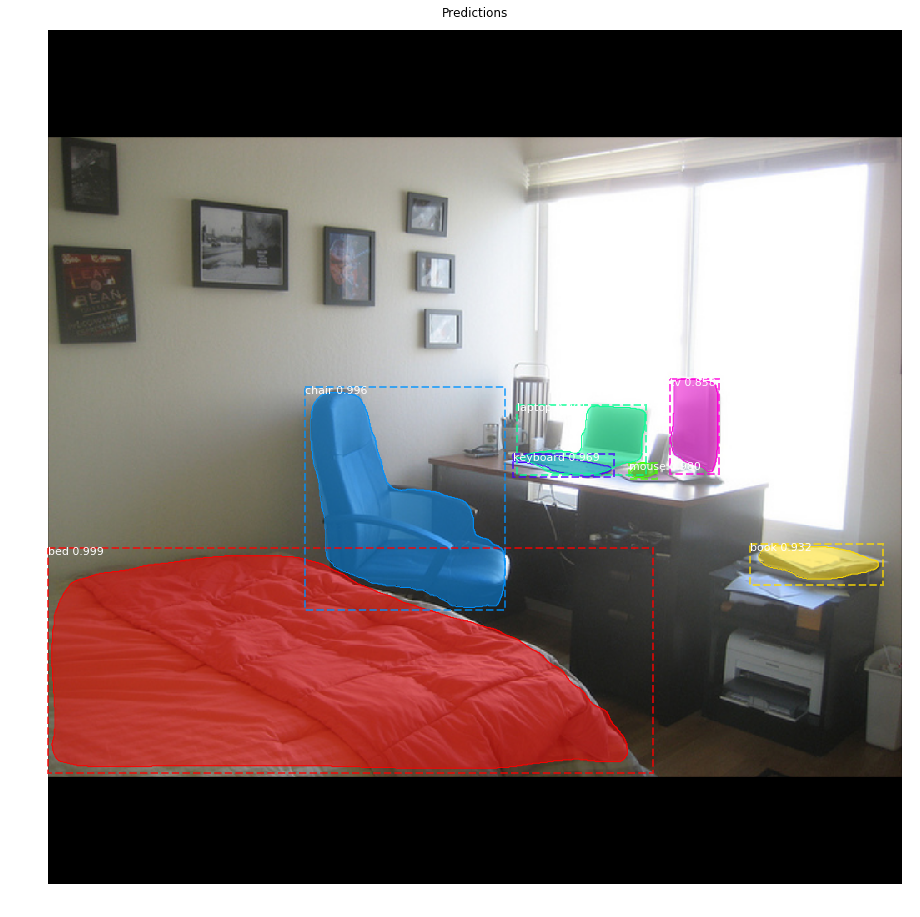

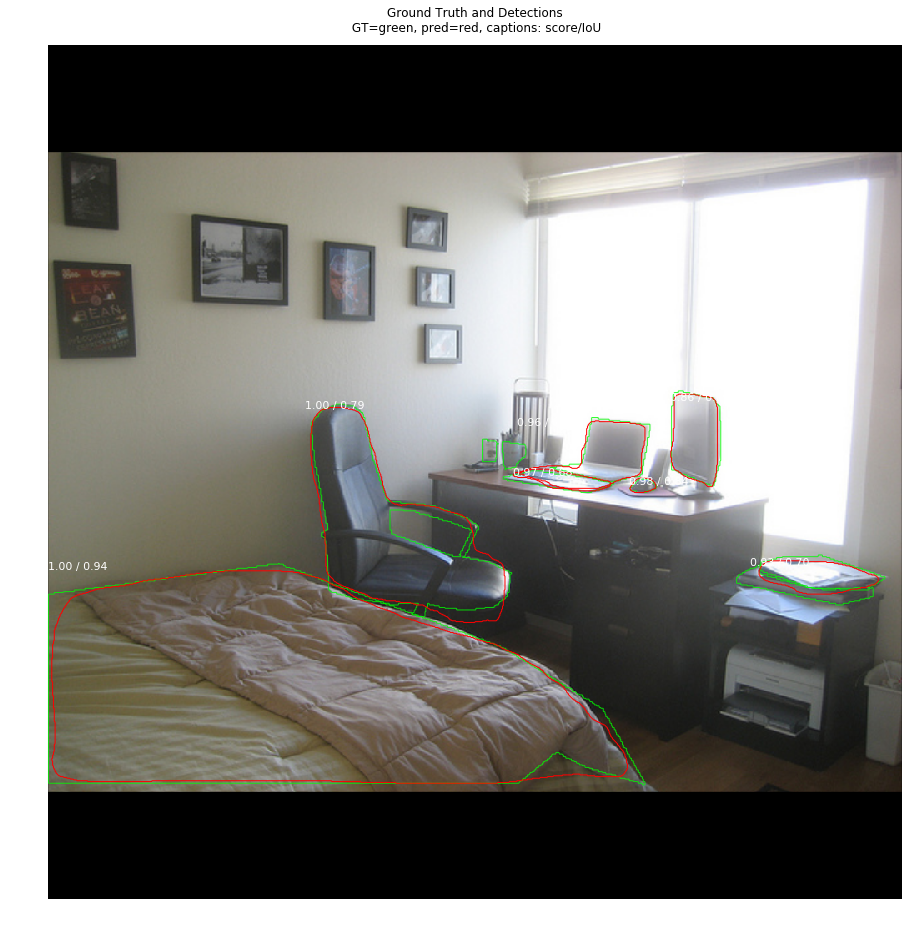

In [42]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
#
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])
#
# Run object detection
#
stime = time.time()
start = timer()
#
results = model.detect([image], verbose=1)

#results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
#
#print('FPS {:.1f}'.format(1 / (time.time() - stime)))  # Frame per seconds
print('\nElapsed time = ' + str(timer() - start) + ' s\n')
#
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

### Precision-Recall

### Compute mAP @ IoU=50 on Batch of Images